In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
#all a single example session

results_paths={}

# results_paths['context']="s3://aind-scratch-data/dynamic-routing/decoding/results/test_0.05s_multi_timebin_0/"
# results_paths['context_baseline_subtract'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtracted_0/"
# results_paths['response'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_0/"
# results_paths['response_baseline_subtract'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_baseline_subtracted_1/"

# results_paths['context_baseline_subtract_vis1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_vis1_only_0/"
# results_paths['context_baseline_subtract_sound1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_sound1_only_0/"

# results_paths['response_baseline_subtract_vis1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_vis1_only_baseline_subtract_20250827_174517/"
# results_paths['response_baseline_subtract_sound1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_sound1_only_baseline_subtract_20250827_174716/"

# results_paths['response_baseline_subtract_unrewarded_target'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_unrewarded_target_baseline_subtract_20250827_224845/"

# results_paths['response_baseline_subtract_sound1_vis_context'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_sound1_in_vis_context_baseline_subtract_20250827_223700/"

# results_paths['context_baseline_subtract_cumulative_0.01'] ="s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_181812/"
# results_paths['context_baseline_subtract_cumulative_0.02'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_185213/"
# results_paths['context_baseline_subtract_cumulative_0.05'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_193324/"
# results_paths['context_cumulative_0.05'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_all_units_20250829_194357/"



# #baseline subtracted, sliding window
results_paths['context_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_no_baseline_subtract_0/"
results_paths['context_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0/"
results_paths['context_aud_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_aud_target_0/"
results_paths['context_vis_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_vis_target_0/"

results_paths['response_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"
results_paths['response_aud_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_aud_target_0/"
results_paths['response_vis_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_vis_target_0/"

# #baseline subtracted, decode stimulus in different contexts
results_paths['aud_stim_in_aud_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_aud_block_baseline_subtract_0/"
results_paths['aud_stim_in_vis_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_vis_block_baseline_subtract_0/"
results_paths['vis_stim_in_aud_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_aud_block_baseline_subtract_0/"
results_paths['vis_stim_in_vis_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_vis_block_baseline_subtract_0/"

#cumulative decoding
results_paths['context_cumulative']=r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_cumulative_10ms_0/"



In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}



In [ ]:
# session-wise average decoding accuracy

def get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping):

    new_results_session_df = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').is_in(dr_session_list),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').not_(),
        )
        #get total n units
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                )
                #make new rows according to structure_grouping
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                    .then(pl.col('structure').repeat_by(n_repeats))
                    .otherwise(pl.col('structure').repeat_by(1))
                )
                .explode('structure')
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                    .then(pl.col('structure').replace(structure_grouping))
                    .otherwise(pl.col('structure'))
                )
                .group_by('session_id','structure')
                .agg(
                    pl.col('unit_id').len().alias('total_n_units')
                )
            ),
            on=['session_id','structure'],
            how='left',
        )
        #join on session table to get cross-modal dprime, etc.
        .join(
            other=session_table.filter(
                pl.col('session_id').is_in(dr_session_list)
            ).select(
                'session_id',
                'n_passing_blocks',
                'cross_modality_dprime_vis_blocks',
                'cross_modality_dprime_aud_blocks',
            ).lazy(),
            on='session_id',
            how='left',
        )
        # get the means for each recording over repeats:
        .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
        .agg(
            pl.col('balanced_accuracy_test').mean(), # over repeats
        )
        # get the aligned result and median over shifts:
        .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                            'cross_modality_dprime_aud_blocks', 'total_n_units'})
        .agg(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
            pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
        )
        # get the difference between true and null:
        .with_columns(
            pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
        )
        .sort('structure', 'unit_subsample_size', descending=False)
        .collect()
    )

    return new_results_session_df.to_pandas()

In [ ]:
results_dfs={}
for key, results_path in results_paths.items():
    print(f"Loading results from {key}...")
    results_dfs[key] = get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping)

In [73]:
#save individual dfs from resuts_dfs as parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\baseline_subtract_decoding_summary_tables-2025-09-11"

# for key, df in results_dfs.items():
#     df.to_parquet(os.path.join(savepath, f"{key}_decoding_summary_table.parquet"))



In [74]:
#load results from parquet files
results_dfs={}
for filename in os.listdir(savepath):
    if filename.endswith("_decoding_summary_table.parquet"):
        key = filename.replace("_decoding_summary_table.parquet", "")
        df = pd.read_parquet(os.path.join(savepath, filename))
        results_dfs[key] = df

In [ ]:
results_dfs[key]['structure'].unique()

In [ ]:
np.sort(results_dfs[key]['bin_center'].unique())*2

In [ ]:

sel_session="664851_2023-11-13"

sel_structure="CP"
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

for key, new_results_session_pd in results_dfs.items():
    print(f"Plotting results from {key}...")

    example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="{sel_time_aligned_to}" ').sort_values('bin_center')
    # if key=='context_baseline_subtract_cumulative_0.01':
    #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
    # else:
    ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label=key)

# ax.set_ylim(0.5,1)

ax.set_xlim(-0.2,0.7)
ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
#place legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [ ]:
# plot average across sessions by structure

# sel_structure="AId"
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"
# time_offset=0.025 #add to bin_centers

# sel_key_set='all_trials'

# key_sets={
#     'all_trials': ['context_all_trials_no_baseline_subtract', 'context_all_trials', 'response_all_trials'],
#     'aud_target': ['context_aud_target', 'response_aud_target', 'aud_stim_in_aud_context', 'aud_stim_in_vis_context'],
#     'vis_target': ['context_vis_target', 'response_vis_target', 'vis_stim_in_aud_context', 'vis_stim_in_vis_context'],
#     'context': ['context_all_trials', 'context_aud_target', 'context_vis_target'],
#     'response': ['response_all_trials', 'response_aud_target', 'response_vis_target'],
# }

key_sets={
    'cumulative_vs_sliding_window': ['context_all_trials', 'context_cumulative'],
}

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-04-baseline_subtract_decoding\by_area"

for sel_key_set in key_sets.keys():

    for sel_structure in results_dfs[key]['structure'].unique():

        fig,ax=plt.subplots(1,1,figsize=(8,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        for key in key_sets[sel_key_set]:
            if 'cumulative' in key:
                time_offset=0.0
            else:
                time_offset=0.025    
            new_results_session_pd = results_dfs[key]
            bins=np.sort(new_results_session_pd['bin_center'].unique())

            print(f"Plotting results from {key}...")

            example_timebin_decoding=[]

            for bb in bins:
                ####have to do something more complicated here to reshape
                example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
            # if key=='context_baseline_subtract_cumulative_0.01':
            #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
            # else:
            ax.plot(bins+time_offset, example_timebin_decoding, label=key)

        # ax.set_ylim(0.5,1)

        ax.set_xlim(-0.1,0.65)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        ax.set_title(f"{sel_structure} ({n_sessions}); {sel_time_aligned_to}; {sel_unit_subsample_size} units")

        fig.tight_layout()
        
        fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key_set}.png"), dpi=300)
        plt.close(fig)

In [ ]:
# example_timebin_decoding
results_dfs.keys()

In [ ]:
#compare each result across strutures

sel_structures=['AUDp','VISp','ACAd','MOs','MOp','ORBl','PL','CP','SCm','MRN']

time_offset=0.025 #add to bin_centers
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"
# # sel_result='response_vis_target' #context_all_trials, context_aud_target, context_vis_target, response_all_trials, response_aud_target, response_vis_target
# sel_result='context_vis_target' #'aud_stim_in_aud_context' #context_all_trials_no_baseline_subtract

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-04-baseline_subtract_decoding"

for key in results_dfs.keys():
    sel_result=key
    if 'cumulative' in key:
        time_offset=0.0
    else:
        time_offset=0.025

    fig,ax=plt.subplots(1,1,figsize=(8,4))
    ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

    bins=np.sort(results_dfs[key]['bin_center'].unique())

    for sel_structure in sel_structures:

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        new_results_session_pd = results_dfs[sel_result]

        example_timebin_decoding=[]

        for bb in bins:
            ####have to do something more complicated here to reshape
            example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                            time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
        # if key=='context_baseline_subtract_cumulative_0.01':
        #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
        # else:
        ax.plot(bins+time_offset, example_timebin_decoding, label=f"{sel_structure} ({n_sessions})")

        # ax.set_ylim(0.5,1)

    ax.set_xlim(-0.1,0.65)
    ax.set_xlabel('time rel to stim onset (s)')
    ax.set_ylabel('decoding accuracy')
    #place legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.legend()
    ax.set_title(f"{sel_result}; {sel_unit_subsample_size} units")

    fig.tight_layout()
    fig.savefig(os.path.join(savepath, f"decode_{sel_result}.png"), dpi=300)

    ax.set_xlim(-0.05,0.2)
    fig.savefig(os.path.join(savepath, f"decode_{sel_result}_zoom.png"), dpi=300)

    plt.close(fig)

In [ ]:
#save average by structure/result plots, compute time to half max, max value, etc.

# time_offset=0.025 #add to bin_centers
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"

mean_result_by_structure={
    'structure': [],
    'result': [],
    'n_sessions': [],
    'bin_centers': [],
    'mean_decoding_accuracy': [],
    'sem_decoding_accuracy': [],
    'max_decoding_accuracy': [],
    'time_to_max': [],
    'time_to_90_pct': [],
    'time_to_half_max': [],
}

for key in results_dfs.keys():
    sel_result=key
    if 'cumulative' in key:
        time_offset=0.0
    else:
        time_offset=0.025
    # bins=np.sort(results_dfs[key]['bin_center'].unique()).round(3)

    for sel_structure in results_dfs[key]['structure'].unique():

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        new_results_session_pd = results_dfs[sel_result]

        # example_timebin_decoding=[]
        # example_timebin_decoding_sem=[]

        # for bb in bins:
        #     ####have to do something more complicated here to reshape
        #     example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
        #                                     time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
        #     example_timebin_decoding_sem.append(stats.sem(new_results_session_pd.query(f'structure=="{sel_structure}" and \
        #                                     time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].values))

        temp_df=new_results_session_pd.query(
            f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}"'
            ).sort_values(
                ['session_id','bin_center']
            ).groupby(['session_id'])

        decoding_result=np.vstack(temp_df['mean_true'].apply(np.array).values)
        bins=temp_df['bin_center'].apply(np.array).values[0].round(3)

        example_timebin_decoding=np.nanmean(decoding_result, axis=0)
        example_timebin_decoding_sem=stats.sem(decoding_result, axis=0, nan_policy='omit')

        max_decoding_accuracy=example_timebin_decoding.max()

        time_to_max=bins[example_timebin_decoding.argmax()]+time_offset
        half_max_value=(max_decoding_accuracy-0.5).max()/2 +0.5
        time_to_half_max=bins[np.where(example_timebin_decoding >= half_max_value)[0][0]]+time_offset
        pct_90_value=(max_decoding_accuracy-0.5).max()*0.9 +0.5
        time_to_90_pct=bins[np.where(example_timebin_decoding >= pct_90_value)[0][0]]+time_offset

        mean_result_by_structure['structure'].append(sel_structure)
        mean_result_by_structure['result'].append(sel_result)
        mean_result_by_structure['n_sessions'].append(n_sessions)
        mean_result_by_structure['bin_centers'].append((bins+time_offset).round(3))
        mean_result_by_structure['mean_decoding_accuracy'].append(example_timebin_decoding)
        mean_result_by_structure['sem_decoding_accuracy'].append(example_timebin_decoding_sem)
        mean_result_by_structure['max_decoding_accuracy'].append(max_decoding_accuracy)
        mean_result_by_structure['time_to_max'].append(time_to_max)
        mean_result_by_structure['time_to_half_max'].append(time_to_half_max)
        mean_result_by_structure['time_to_90_pct'].append(time_to_90_pct)
        # print(f"Processed {sel_structure} for {sel_result} ({n_sessions} sessions)")

mean_result_by_structure_df=pd.DataFrame(mean_result_by_structure)


In [ ]:
# mean_result_by_structure_df=pd.DataFrame(mean_result_by_structure)
mean_result_by_structure_df.query('result=="context_cumulative" and n_sessions>=5 and max_decoding_accuracy>=0.60')
# mean_result_by_structure_df.query('structure=="ORBl"')

In [ ]:
sel_structure='MOs'
sel_session="664851_2023-11-13"
test_vect=new_results_session_pd.query(f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}" and session_id=="{sel_session}"').sort_values('bin_center')['mean_true'].values
test_bins=new_results_session_pd.query(f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}" and session_id=="{sel_session}"').sort_values('bin_center')['bin_center'].values

half_max_value=(test_vect-0.5).max()/2 +0.5
time_to_half_max=test_bins[np.where(test_vect >= half_max_value)[0][0]]

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(test_bins, test_vect)
ax.plot(time_to_half_max, half_max_value, 'ro')
ax.set_title(f"{sel_session}; {sel_structure}; time to half max: {time_to_half_max:.3f}s")

In [ ]:
test_df=new_results_session_pd.query(
    f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}"'
    ).sort_values(
        ['session_id','bin_center']
    ).groupby(['session_id'])

half_max_value=[]
time_to_half_max=[]

decoding_result=np.vstack(test_df['mean_true'].apply(np.array).values)
bins=test_df['bin_center'].apply(np.array).values[0]

for ii in range(decoding_result.shape[0]):
    half_max_value.append((decoding_result[ii,:]-0.5).max()/2 +0.5)
    time_to_half_max.append(bins[np.where(decoding_result[ii,:] >= half_max_value[-1])[0][0]])

mean_half_max_value=np.mean(half_max_value)
mean_time_to_half_max=np.mean(time_to_half_max)

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(bins, decoding_result.T, color='lightgrey', alpha=0.5)
ax.plot(bins, decoding_result.mean(axis=0), color='blue')
ax.plot(time_to_half_max, half_max_value, 'ro')
ax.plot(mean_time_to_half_max, mean_half_max_value, 'go')

In [ ]:
# test_df['mean_true'].apply(np.array).values
# test_df['bin_center'].apply(np.array).values[0]
# results[0].shape
bins[1]+time_offset

In [22]:
def get_session_results(session_id,results_path,grouping_cols,combine_multi_probe_expr):

    decoder_coefs = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').eq(session_id),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').eq(True),
        )
        .sort('structure', 'shift_idx', 'repeat_idx', 'time_aligned_to', 'bin_center', descending=False, maintain_order=True)
        .with_columns([
            pl.col("electrode_group_names").list.n_unique().alias("n_probes"),
            pl.col("electrode_group_names")
            .list.eval(pl.element().str.replace("probe", ""))
            .list.join("")
            .alias("probe")
        ])
        .drop('predict_proba','predict_proba_all_trials','trial_indices','electrode_group_names','repeat_idx','shift_idx','unit_subsample_size','unit_criteria','is_sole_recording','is_all_trials','time_aligned_to')
        .collect()
    )

    return decoder_coefs #.to_pandas()

def get_session_coef_results(session_id,results_paths):

    session_coef_dfs={}

    for key, results_path in results_paths.items():
        print(f"Loading results from {key}...")
        session_coef_dfs[key] = pl.scan_parquet(results_path).filter(pl.col('session_id').eq(session_id)).collect().to_pandas()

    return session_coef_dfs

In [19]:
#test loading the whole result path

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15"

for key in results_paths.keys():

    if key=='context_all_trials':
        continue
    print(f"Loading full results from {key}...")

    results_path=results_paths[key]

    decoder_coefs = (
        pl.scan_parquet(results_path)
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').eq(True),
        )
        .sort('structure', 'shift_idx', 'repeat_idx', 'time_aligned_to', 'bin_center', descending=False, maintain_order=True)
        .with_columns([
            pl.col("electrode_group_names").list.n_unique().alias("n_probes"),
            pl.col("electrode_group_names")
            .list.eval(pl.element().str.replace("probe", ""))
            .list.join("")
            .alias("probe")
        ])
        .drop('predict_proba','predict_proba_all_trials','trial_indices','electrode_group_names','repeat_idx','shift_idx','unit_subsample_size','unit_criteria','is_sole_recording','is_all_trials','time_aligned_to')
        .collect()
    )
    print(f"Loaded {decoder_coefs.shape[0]} rows from {key}.")
    decoder_coefs.write_parquet(os.path.join(savepath, key + "_decoder_coefs.parquet"))


Loading full results from context_all_trials_no_baseline_subtract...
Loaded 157570 rows from context_all_trials_no_baseline_subtract.
Loading full results from context_aud_target...
Loaded 153790 rows from context_aud_target.
Loading full results from context_vis_target...
Loaded 143640 rows from context_vis_target.
Loading full results from response_all_trials...
Loaded 157570 rows from response_all_trials.
Loading full results from response_aud_target...
Loaded 143850 rows from response_aud_target.
Loading full results from response_vis_target...
Loaded 136570 rows from response_vis_target.
Loading full results from aud_stim_in_aud_context...
Loaded 141820 rows from aud_stim_in_aud_context.
Loading full results from aud_stim_in_vis_context...
Loaded 141820 rows from aud_stim_in_vis_context.
Loading full results from vis_stim_in_aud_context...
Loaded 139860 rows from vis_stim_in_aud_context.
Loading full results from vis_stim_in_vis_context...
Loaded 141820 rows from vis_stim_in_vis_c

In [21]:
# decoder_coefs.write_parquet(r"D:\context_all_trials_decoder_coefs.parquet")
results_paths_processed={
    'context_all_trials_no_baseline_subtract': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_all_trials_no_baseline_subtract_decoder_coefs.parquet",
    'context_all_trials': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_all_trials_decoder_coefs.parquet",
    'context_aud_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_aud_target_decoder_coefs.parquet",
    'context_vis_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_vis_target_decoder_coefs.parquet",
    'response_all_trials': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\response_all_trials_decoder_coefs.parquet",
    'response_aud_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\response_aud_target_decoder_coefs.parquet",
    'response_vis_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\response_vis_target_decoder_coefs.parquet",
    'aud_stim_in_aud_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\aud_stim_in_aud_context_decoder_coefs.parquet",
    'aud_stim_in_vis_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\aud_stim_in_vis_context_decoder_coefs.parquet",
    'vis_stim_in_aud_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\vis_stim_in_aud_context_decoder_coefs.parquet",
    'vis_stim_in_vis_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\vis_stim_in_vis_context_decoder_coefs.parquet",
    'context_cumulative': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_cumulative_decoder_coefs.parquet",
}

In [69]:

sel_session_id="664851_2023-11-13"
results_key_0='context_aud_target'
results_key_1='response_aud_target'
results_path_0=results_paths[results_key_0]
results_path_1=results_paths[results_key_1]

decoder_coefs_pd_0 = get_session_results(sel_session_id, results_path_0, grouping_cols, combine_multi_probe_expr)
decoder_coefs_pd_1 = get_session_results(sel_session_id, results_path_1, grouping_cols, combine_multi_probe_expr)


In [23]:
sel_session_id="664851_2023-11-13"
session_coef_dfs = get_session_coef_results(sel_session_id, results_paths_processed)

Loading results from context_all_trials_no_baseline_subtract...
Loading results from context_all_trials...
Loading results from context_aud_target...
Loading results from context_vis_target...
Loading results from response_all_trials...
Loading results from response_aud_target...
Loading results from response_vis_target...
Loading results from aud_stim_in_aud_context...
Loading results from aud_stim_in_vis_context...
Loading results from vis_stim_in_aud_context...
Loading results from vis_stim_in_vis_context...
Loading results from context_cumulative...


In [ ]:
corrcoef_by_timepoint={
    'results_key_0': [],
    'results_key_1': [],
    'structure': [],
    'bin_center': [],
    'bin_center_1': [],
    'corrcoef': [],
    'cosine_similarity': [],
    'euclidean_distance': [],
}

#get unique structures across all results
unique_structures = set()
for df in session_coef_dfs.values():
    unique_structures.update(df['structure'].unique())
unique_structures = sorted(unique_structures)

# make list of all combinations of results keys
results_keys = list(session_coef_dfs.keys())
combinations = [(key0, key1) for i, key0 in enumerate(results_keys) for key1 in results_keys[i+1:]]

# loop through combinations of results keys
for key0, key1 in combinations:

    # find correlation between coefs
    df0 = session_coef_dfs[key0]
    df1 = session_coef_dfs[key1]

    #round bin centers to 3 decimal places
    df0['bin_center'] = df0['bin_center'].round(3)
    df1['bin_center'] = df1['bin_center'].round(3)

    #check that timepoints match up
    timepoints0 = df0.query('structure==@structure')['bin_center'].unique()
    timepoints1 = df1.query('structure==@structure')['bin_center'].unique()

    if 'cumulative' not in key0:
        timepoints0 = timepoints0 + 0.025
    if 'cumulative' not in key1:
        timepoints1 = timepoints1 + 0.025

    if not np.array_equal(timepoints0, timepoints1):
        print(f"Timepoints do not match for {key1} and {key0} in structure {structure}. Finding best match.")
        #find closest timepoints
        new_timepoints1 = []
        for tp0 in timepoints0:
            closest_tp1 = timepoints1[np.abs(timepoints1 - tp0).argmin()]
            if np.abs(closest_tp1 - tp0) >= 0.01:
                print(f"No close match for timepoint {tp0} in {key1}. Skipping.")
                continue
            print(f"Matching timepoint {tp0} in {key1} to {closest_tp1} in {key0}.")
            new_timepoints1.append(closest_tp1)
        timepoints1 = np.array(new_timepoints1)

        # loop through structures
        for structure in unique_structures:

            #loop through timepoints
            timepoints0 = df0.query('structure==@structure')['bin_center'].unique()  
            timepoints1 = df1.query('structure==@structure')['bin_center'].unique()
            for timepoint0,timepoint1 in zip(timepoints0, timepoints1):

                vec0=df0.query('structure==@structure and bin_center==@timepoint0')['coefs'].values[0]
                vec1=df1.query('structure==@structure and bin_center==@timepoint1')['coefs'].values[0]
                corr=np.corrcoef(vec0, vec1)[0,1]
                cosine_sim = np.dot(vec0, vec1) / (np.linalg.norm(vec0) * np.linalg.norm(vec1))
                euclidean_dist = np.linalg.norm(vec0 - vec1)
                
                corrcoef_by_timepoint['results_key_0'].append(key0)
                corrcoef_by_timepoint['results_key_1'].append(key1)
                corrcoef_by_timepoint['structure'].append(structure)
                corrcoef_by_timepoint['bin_center'].append(timepoint0 if 'cumulative' in key0 else timepoint0 + 0.025)
                corrcoef_by_timepoint['bin_center_1'].append(timepoint1 if 'cumulative' in key1 else timepoint1 + 0.025)
                corrcoef_by_timepoint['corrcoef'].append(corr)
                corrcoef_by_timepoint['cosine_similarity'].append(cosine_sim)
                corrcoef_by_timepoint['euclidean_distance'].append(euclidean_dist)


Timepoints do not match for context_cumulative and context_all_trials_no_baseline_subtract in structure ACAd. Finding best match.
No close match for timepoint -0.07 in context_cumulative. Skipping.
No close match for timepoint -0.060000000000000005 in context_cumulative. Skipping.
No close match for timepoint -0.049999999999999996 in context_cumulative. Skipping.
No close match for timepoint -0.04 in context_cumulative. Skipping.
No close match for timepoint -0.03 in context_cumulative. Skipping.
No close match for timepoint -0.019999999999999997 in context_cumulative. Skipping.
No close match for timepoint -0.010000000000000002 in context_cumulative. Skipping.
No close match for timepoint 0.0 in context_cumulative. Skipping.
Matching timepoint 0.010000000000000002 in context_cumulative to 0.01 in context_all_trials_no_baseline_subtract.
Matching timepoint 0.02 in context_cumulative to 0.02 in context_all_trials_no_baseline_subtract.
Matching timepoint 0.030000000000000002 in context_c

In [81]:
df0.query('structure==@structure and bin_center==@timepoint0')

,balanced_accuracy_test,balanced_accuracy_train,bin_size,bin_center,unit_ids,coefs,session_id,structure,n_probes,probe


In [77]:
corrcoef_by_timepoint_df=pd.DataFrame(corrcoef_by_timepoint)
corrcoef_by_timepoint_df

,results_key_0,results_key_1,structure,bin_center,corrcoef,cosine_similarity,euclidean_distance
0,context_all_trials_no_baseline_subtract,context_all_trials,ACAd,-0.095,0.516726,0.516869,4.377473
1,context_all_trials_no_baseline_subtract,context_all_trials,ACAd,-0.085,0.436300,0.437111,4.150718
2,context_all_trials_no_baseline_subtract,context_all_trials,ACAd,-0.075,0.392834,0.396828,4.223939
3,context_all_trials_no_baseline_subtract,context_all_trials,ACAd,-0.065,0.467662,0.471537,4.342344
4,context_all_trials_no_baseline_subtract,context_all_trials,ACAd,-0.055,0.417418,0.416306,4.800692
...,...,...,...,...,...,...,...
69295,vis_stim_in_aud_context,vis_stim_in_vis_context,VPM,0.555,0.288929,0.268101,3.666995
69296,vis_stim_in_aud_context,vis_stim_in_vis_context,VPM,0.565,0.187150,0.181829,3.850807
69297,vis_stim_in_aud_context,vis_stim_in_vis_context,VPM,0.575,0.233056,0.224885,3.740624
69298,vis_stim_in_aud_context,vis_stim_in_vis_context,VPM,0.585,0.296680,0.288807,3.513580


Text(0.5, 1.0, 'Correlation of decoder coefficients\nVPM at 0.105s; session 664851_2023-11-13')

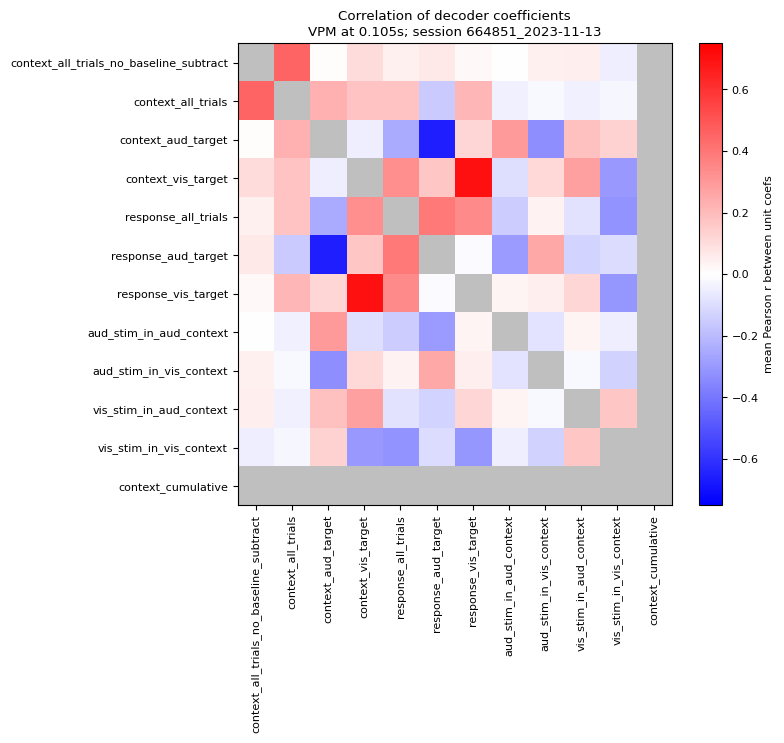

In [ ]:
corrcoef_by_timepoint_df['bin_center']=corrcoef_by_timepoint_df['bin_center'].round(3)

#plot heatmap of correlation coefficients for each results pair
sel_structure='ACAd'
sel_bin_center=0.105

#build correlation matrix from this dataframe
corr_matrix=np.full((len(results_keys), len(results_keys)), np.nan)
for rr, sel_key_0 in enumerate(results_keys):
    for cc, sel_key_1 in enumerate(results_keys):
        if sel_key_0==sel_key_1:
            corr_matrix[rr,cc]=np.nan
        else:
            temp_corr=corrcoef_by_timepoint_df.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
                                                   structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef'].values
            if len(temp_corr)==1:
                corr_matrix[rr,cc]=temp_corr[0]
                corr_matrix[cc,rr]=temp_corr[0]

fig,ax=plt.subplots(1,1,figsize=(7,6))

masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

im=ax.imshow(masked_array, aspect='auto', cmap=cmap, vmin=-0.75, vmax=0.75, extent=[-0.5,len(results_keys)-0.5,len(results_keys)-0.5,-0.5])
ax.set_xticks(np.arange(len(results_keys)), results_keys, rotation=90)
ax.set_yticks(np.arange(len(results_keys)), results_keys)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between unit coefs')

ax.set_title(f"Correlation of decoder coefficients\n{sel_structure} at {sel_bin_center}s; session {sel_session_id}")


### does the sign of the correlation matter??

In [ ]:
# decoder_coefs_pd_0.write_parquet(r"D:\decoder_coefs_vis_stim_in_aud_context_664851_2023-11-13.parquet")

In [ ]:
# decoder_coefs_pd_1

In [71]:
corrcoef_by_timepoint={
    'structure': [],
    'bin_center': [],
    'corrcoef': [],
}

decoder_coefs_pd_0=decoder_coefs_pd_0.to_pandas()
decoder_coefs_pd_1=decoder_coefs_pd_1.to_pandas()

for sel_structure in decoder_coefs_pd_0['structure'].unique():
    print(f"Processing {sel_structure}...")
    for sel_bin in decoder_coefs_pd_0.query(f'structure=="{sel_structure}"')['bin_center'].unique():
        
        unit_ids_0=decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['unit_ids'].values[0]
        unit_ids_1=decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['unit_ids'].values[0]

        if np.any(unit_ids_0!=unit_ids_1):
            print(f"Unit IDs do not match for {sel_structure} at bin {sel_bin}, try sorting...")
            unit_ids_0_sorted=np.sort(unit_ids_0)
            unit_ids_1_sorted=np.sort(unit_ids_1)
            if not np.array_equal(unit_ids_0_sorted, unit_ids_1_sorted):
                print(f"Unit IDs still do not match for {sel_structure} at bin {sel_bin}, skipping...")
                continue
            else:
                print(f"Unit IDs match after sorting for {sel_structure} at bin {sel_bin}, proceeding...")
                #get sorting indices
                sort_idx_0 = np.argsort(unit_ids_0)
                sort_idx_1 = np.argsort(unit_ids_1)

                #sort coefs
                decoder_coefs_pd_0.loc[(decoder_coefs_pd_0['structure']==sel_structure) & (decoder_coefs_pd_0['bin_center']==sel_bin), 'coefs'] = [
                    decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0][sort_idx_0]
                    ]
                decoder_coefs_pd_1.loc[(decoder_coefs_pd_1['structure']==sel_structure) & (decoder_coefs_pd_1['bin_center']==sel_bin), 'coefs'] = [
                    decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0][sort_idx_1]
                    ]

        vec_0=decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0]
        vec_1=decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0]

        if len(vec_0)==len(vec_1) and len(vec_0)>0:
            corrcoef_by_timepoint['structure'].append(sel_structure)
            corrcoef_by_timepoint['bin_center'].append(sel_bin)
            corrcoef_by_timepoint['corrcoef'].append(np.corrcoef(vec_0, vec_1)[0,1])

corrcoef_by_timepoint_df=pd.DataFrame(corrcoef_by_timepoint)

Processing ACAd...
Processing ACAv...
Processing CP...
Processing FRP...
Processing ILA...
Processing MOs...
Processing ORBl...
Processing PAG...
Processing RSPagl...
Processing RSPd...
Processing RSPv...
Processing SCig...
Processing SCm...
Processing SCs...
Processing SSp...
Processing VISam...
Processing VPL...
Processing VPM...


In [ ]:
# np.any(unit_ids_0!=unit_ids_1)
# decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['unit_ids'].values

Text(0.5, 1.0, 'correlation between decoder weights on units')

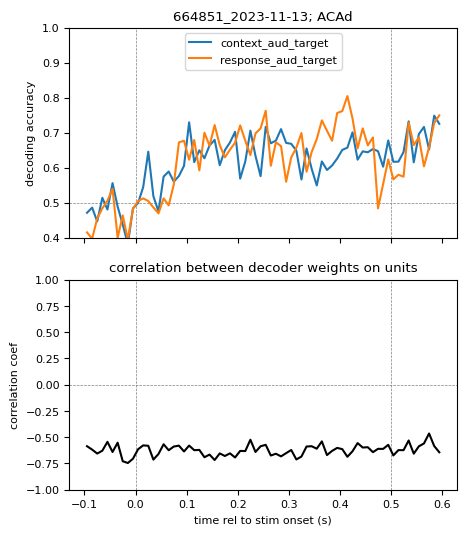

In [75]:
sel_structure='ACAd'
sel_session_id="664851_2023-11-13"

structure_coefs=corrcoef_by_timepoint_df.query(f'structure=="{sel_structure}"').sort_values('bin_center')
result_0=results_dfs[results_key_0].query(f'structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values('bin_center')
result_1=results_dfs[results_key_1].query(f'structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values('bin_center')

fig,ax=plt.subplots(2,1,figsize=(5,6),sharex=True)
ax[0].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[0].axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax[0].axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax[0].plot(result_0['bin_center'], result_0['mean_true'], label=results_key_0)
ax[0].plot(result_1['bin_center'], result_1['mean_true'], label=results_key_1)
ax[0].set_title(f"{sel_session_id}; {sel_structure}")
ax[0].set_ylabel('decoding accuracy')
ax[0].set_ylim(0.4,1)
ax[0].legend()

ax[1].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax[1].plot(structure_coefs['bin_center'], structure_coefs['corrcoef'],label='coef corr', color='black')
ax[1].set_xlabel('time rel to stim onset (s)')
ax[1].set_ylabel('correlation coef')
ax[1].set_ylim(-1,1)
ax[1].set_title('correlation between decoder weights on units')
# ax[1].legend()

In [ ]:
# what are all the comparisons I'm interested in?

# or just compare every pair...11 results = 55 pairs?

# option - save intermediate results -- table with coefs organized in convenient way, or by result (only load from each path once)

# 

results_comparisons = [
    ['context_all_trials', 'context_all_trials_no_baseline_subtract'],
    ['context_all_trials', 'response_all_trials'],
    ['context_aud_target', 'response_aud_target'],
    ['context_vis_target', 'response_vis_target'],
    ['context_aud_target', 'context_vis_target'],
    ['response_aud_target', 'response_vis_target'],
    ['aud_stim_in_aud_context', 'aud_stim_in_vis_context'],
    ['vis_stim_in_aud_context', 'vis_stim_in_vis_context'],
    ['context_aud_target', 'aud_stim_in_aud_context'],
    ['context_vis_target', 'vis_stim_in_vis_context'],

    #['context_all_trials', 'context_cumulative'], #needs work matching up bins
]

In [ ]:

sel_session="664851_2023-11-13"

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\test_baseline_subtraction_and_lick_decoding_2025-08-28"

sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"

unique_structures=results_dfs[key]['structure'].unique()

sel_results_to_plot = [
    ['context', 'context_baseline_subtract'],
    ['response', 'response_baseline_subtract'],
    ['context_baseline_subtract','response_baseline_subtract'],
    ['context_baseline_subtract', 'context_baseline_subtract_vis1_only', 'context_baseline_subtract_sound1_only'],
    ['response_baseline_subtract', 'response_baseline_subtract_vis1_only', 'response_baseline_subtract_sound1_only'],
    ['context_baseline_subtract_vis1_only', 'response_baseline_subtract_vis1_only',],
    ['context_baseline_subtract_sound1_only', 'response_baseline_subtract_sound1_only',],
]

for sel_structure in unique_structures:
    plot_idx=0
    for results_to_plot in sel_results_to_plot:

        fig,ax=plt.subplots(1,1,figsize=(5,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        for key in results_to_plot:
            new_results_session_pd = results_dfs[key]

            example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')

            linestyle='-'
            if 'vis' in key:
                color='tab:green'
                if 'response' in key:
                    linestyle='--'
            elif 'sound' in key:
                color='tab:pink'
                if 'response' in key:
                    linestyle='--'
            elif key=="context" or key=="response":
                color='k'
            elif key=='context_baseline_subtract':
                color='tab:blue'
            elif key=='response_baseline_subtract':
                color='tab:orange'

            ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label=key, color=color, linestyle=linestyle)

        # ax.set_ylim(0.5,1)

        ax.set_xlim(-0.2,0.7)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

        fig.savefig(os.path.join(savepath, f"{sel_session}_{sel_structure}_{sel_unit_subsample_size}units_"+str(plot_idx)+ ".png"), 
                    bbox_inches='tight',dpi=300)
        plt.close(fig)

        plot_idx+=1

